In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True) 
root = "/content/drive/MyDrive/final/"
# IF not running in colab, commet above and uncomment below
# root = "./"

!pip install transformers sentencepiece

from transformers             import AutoTokenizer, AutoModel, AutoModelForSequenceClassification, AutoConfig,Trainer, TrainingArguments, BertweetTokenizer, BertConfig, RobertaModel,RobertaTokenizer, XLMRobertaTokenizer, XLMRobertaModel
from torch.utils.data         import Dataset, DataLoader, TensorDataset, RandomSampler, SequentialSampler
from sklearn.metrics          import f1_score, roc_auc_score, balanced_accuracy_score, mean_squared_error, confusion_matrix, accuracy_score
from sklearn.model_selection  import train_test_split
from collections              import Counter
from tqdm                     import tqdm
from torch.nn.utils.rnn       import pad_sequence

import matplotlib.pyplot   as plt
import torch.nn.functional as F
import numpy  as np
import pandas as pd

import copy
import torch
import os
import random
import re
import gc
import csv

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

Mounted at /content/drive
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


device(type='cuda')

In [ ]:
# only to train
DATASET_PATH = "dataset/"

DATA1_KAGGLE_PATH     = 'clickbait_data.csv'
DATA2_ClickBait_PATH  = 'clickbait.txt'
DATA2_Genuine_PATH    = 'genuine.txt'
WEBIS_TRAIN_PATH      = 'webis_train.csv'
WEBIS_TEST_PATH       = 'webis_test.csv'

ColumnData  = 'headline'
ColumnLabel = 'clickbait'

def readTxt(filePath):
  filePath =  filePath
  with open(filePath, "r") as f:
    sentence = []
    line = f.readline()
    while line:
      sentence.append(line.rstrip('\n'))      
      line = f.readline()
    
    return sentence

# Prepare DATA 1: kaggle clicbait challenge
df_DataA = pd.read_csv(root + DATASET_PATH + DATA1_KAGGLE_PATH)

# Prepare DATA 2: Mathur's dataset 
clickBait     = readTxt(root + DATASET_PATH +DATA2_ClickBait_PATH)
nonClickBait  = readTxt(root + DATASET_PATH +DATA2_Genuine_PATH)

labelA = [1] * len(clickBait)
labelB = [0] * len(nonClickBait)

datasetB_X = clickBait + nonClickBait
datasetB_Y = labelA + labelB

dataB_text = np.array(datasetB_X, dtype = object)
dataB_labels = np.array(datasetB_Y)
dataBDict = {'headline': dataB_text, 'clickbait': dataB_labels}

df_DataB = pd.DataFrame(dataBDict)

# Prepare DATA 3: Webis 2017
usedCol = ['postText', 'truthClass']
df_Data_C_train = pd.read_csv(root + DATASET_PATH + WEBIS_TRAIN_PATH, usecols = usedCol)
df_Data_C_test  = pd.read_csv(root + DATASET_PATH + WEBIS_TEST_PATH, usecols = usedCol)
df_Data_C_train = df_Data_C_train.rename(columns={'postText': 'headline', 'truthClass':'clickbait'})
df_Data_C_test  = df_Data_C_test.rename(columns={'postText': 'headline', 'truthClass':'clickbait'})

# Remove commas.
def removeComma(df):
  df['headline'] = df['headline'].str.replace(',', '')
  return df
  
df_DataA = removeComma(df_DataA)
df_DataB = removeComma(df_DataB)
df_Data_C_train = removeComma(df_Data_C_train)
df_Data_C_train['clickbait'] = df_Data_C_train['clickbait'].replace({'no-clickbait': 0, 'clickbait': 1})
df_Data_C_test  = removeComma(df_Data_C_test)
df_Data_C_test['clickbait'] = df_Data_C_test['clickbait'].replace({'no-clickbait': 0, 'clickbait': 1})

df_DataC = pd.concat([df_Data_C_train, df_Data_C_test])
df_DataC['clickbait'] = df_DataC['clickbait'].replace({'no-clickbait': 0, 'clickbait': 1})

df_DataABC = pd.concat([df_DataA, df_DataB, df_DataC])

ParserError: ignored

In [ ]:
# only to train 
mixeddf = pd.read_csv(root + DATASET_PATH + "click-real-train.csv")
mixeddf = mixeddf.rename(columns={'title': 'headline', 'label':'clickbait'})
del mixeddf[mixeddf.columns[0]]
mixeddf['headline'] = mixeddf['headline'].apply(str)
mixeddf['clickbait'] = mixeddf['clickbait'].replace({1: 0, 0: 1})

# only to train 
mixeddf1 = pd.read_csv(root + DATASET_PATH + "click-real-test.csv")
mixeddf1 = mixeddf1.rename(columns={'title': 'headline', 'label':'clickbait'})
del mixeddf1[mixeddf1.columns[0]]
mixeddf1['headline'] = mixeddf1['headline'].apply(str)
mixeddf1['clickbait'] = mixeddf1['clickbait'].replace({1: 0, 0: 1})

In [ ]:
# only to train 

X2 = df_DataABC['headline']
y2 = df_DataABC['clickbait']

X_train, X_test, y_train, y_test = train_test_split(X2,y2,test_size=0.2, random_state=42)

df_DataFIN = mixeddf.copy(deep=True)
X = df_DataFIN['headline']
y = df_DataFIN['clickbait']

traindf = pd.DataFrame()
traindf['headline']  = pd.concat([X,X_train])
traindf['clickbait'] = pd.concat([y,y_train])
traindf = traindf.dropna(subset=['headline'])
traindf['headline'] = traindf['headline'].apply(str.lower)
print(traindf)

df_DataFIN1 = mixeddf1.copy(deep=True)
X1 = df_DataFIN1['headline']
y1 = df_DataFIN1['clickbait']

testdf = pd.DataFrame()
testdf['headline'] = pd.concat([X1,X_test])
testdf['clickbait'] = pd.concat([y1,y_test])
testdf = testdf.dropna(subset=['headline'])
testdf['headline'] = testdf['headline'].apply(str.lower)
print(testdf)

                                                headline  clickbait
0                the seventies give nostalgia a bad name          0
1             five best ways to deal with the worst boss          1
2      grain lower, livestock mostly higher - houston...          0
3      hitting rewind in rerun season: dvd's culled f...          0
4      football star in connecticut killed on eve of ...          0
...                                                  ...        ...
5194   i tried some monolid makeup hacks and they wer...          1
6265        17 things you should know before going vegan          1
11019  🤔🤔🤔 the white house website is suddenly not av...          0
860    16 photos from the delhi queer pride parade th...          1
15795             33 of the most canadian sentences ever          1

[305808 rows x 2 columns]
                                                headline  clickbait
0      ‘say what now’? looks like john kerry’s not to...          1
1      birds mysterio

<ipython-input-5-740accf92e7e>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testdf['headline'] = testdf['headline'].apply(str.lower)


In [ ]:
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
bertmodel = RobertaModel.from_pretrained("roberta-base", output_hidden_states=True).to(device)

def getBertEncodings(text):
    input_ids = (tokenizer.encode(text,add_special_tokens=True, return_tensors='pt' ))
    outputs = bertmodel((input_ids.to(device)))
    embeddings = outputs[0]
    sentence_embedding = torch.mean(embeddings, dim=1)
    return sentence_embedding

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
# only to train 
torch.set_printoptions(threshold=1090)
f = open(root + "ebd/trainebdFIN2.tsv", 'x')
c = csv.writer(f, delimiter='\t')
c.writerow(["embedding", "label"])
with torch.no_grad():
    for index, row in traindf.iterrows():
            try:
                text = row['headline']
                embedding = getBertEncodings(text).to(device)
                row['headline'] = embedding
                c.writerow([row['headline'], row['clickbait']])
            except Exception as e:
                print(row['headline'])
                print(str(e))

f.close() 

f = open(root + "ebd/testebdFIN2.tsv", 'x')
c = csv.writer(f, delimiter='\t')
c.writerow(["embedding", "label"])
with torch.no_grad():
    for index, row in testdf.iterrows():
            try:
                text = row['headline']
                embedding = getBertEncodings(text).to(device)
                row['headline'] = embedding
                c.writerow([row['headline'], row['clickbait']])
            except:
                print(row['headline'])
f.close()

In [ ]:
class Mod(torch.nn.Module):
  def __init__(self, num_hidden, num_outs):
    super().__init__()
    self.fc1 = torch.nn.Linear(768,num_hidden)    
    self.drop = torch.nn.Dropout(0.33)
    self.hidden = torch.nn.Linear(num_hidden,num_outs)

  def forward(self,x):
    x = torch.nn.functional.relu(self.fc1(x))
    x = self.drop(x)
    return self.hidden(x)

model = Mod(num_hidden = 300, num_outs = 2).to(device) 
#model.load_state_dict(torch.load("model_trained_on_fakeddit.pt"))#,state_dict="state_dict")
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = torch.nn.CrossEntropyLoss()
epochs = 5

In [ ]:
comtest = pd.read_csv(root + DATASET_PATH + "mixed_click.csv")
comtest = comtest.rename(columns={'title': 'headline', 'label':'fake_news'})
del comtest[comtest.columns[0]]
comtest['headline'] = comtest['headline'].apply(str)


In [ ]:
testdf = pd.DataFrame()
testdf = comtest
testdf = testdf.dropna(subset=['headline'])
testdf['headline'] = testdf['headline'].apply(str.lower)
print(testdf)

                                             headline  fake_news
0   ‘say what now’? looks like john kerry’s not to...          0
1   birds mysteriously drop dead from the sky in t...          0
2                           austin gillespie archives          0
3   american young performs 'soldier's wife' | on air          1
4              shattering barriers for women in track          1
5   hateful right-wing windbag phyllis schlafly wa...          0
6   ducks trade f michael sgarbossa to florida for...          1
7         planned parenthood at georgetown university          0
8   send him packing: corrupt gop rep. don young s...          0
9                                         corrections          1
10  tx gov. candidate greg abbott victim of his ow...          0
11                               quotation of the day          1
12  the republican party has institutionalized dis...          0
13                                        corrections          1
14    carol burnett, arme

In [ ]:
f = open(root + "ebd/mixed_click_in_fake1.tsv", 'x')
c = csv.writer(f, delimiter='\t')
c.writerow(["embedding", "label"])
with torch.no_grad():
    for index, row in testdf.iterrows():
            try:
                text = row['headline']
                embedding = getBertEncodings(text).to(device)
                row['headline'] = embedding
                c.writerow([row['headline'], row['fake_news']])
            except:
                print(row['headline'])
f.close()

In [ ]:
# both train and test 
train2df = pd.read_csv(root + "/ebd/trainebdFIN2.tsv", delimiter="\t")
test2df = pd.read_csv(root + '/ebd/testebdFIN2.tsv', delimiter='\t')

from torch import tensor
def converter(x):
    return eval(x)
    
train2df['embedding'] = train2df['embedding'].apply(converter)
test2df['embedding'] = test2df['embedding'].apply(converter)

trainset = TensorDataset(torch.stack(list(train2df['embedding'])), torch.LongTensor(list(train2df['label'])))
trainloader = DataLoader(trainset)

testset = TensorDataset(torch.stack(list(test2df['embedding'])), torch.LongTensor(list(test2df['label'])))
testloader = DataLoader(testset)
print(len(testloader))

KeyboardInterrupt: ignored

In [ ]:
# both train and test 
test2df = pd.read_csv(root + 'ebd/mixed_fake_in_click1.tsv', delimiter='\t')

from torch import tensor
def converter(x):
    return eval(x)
    
test2df['embedding'] = test2df['embedding'].apply(converter)

testset = TensorDataset(torch.stack(list(test2df['embedding'])), torch.LongTensor(list(test2df['label'])))
testloader = DataLoader(testset)
print(len(testloader))

# both train and test 
test2dfn = pd.read_csv(root + 'ebd/mixed_click_in_fake1.tsv', delimiter='\t')

from torch import tensor
def converter(x):
    return eval(x)
    
test2dfn['embedding'] = test2dfn['embedding'].apply(converter)

testsetn = TensorDataset(torch.stack(list(test2dfn['embedding'])), torch.LongTensor(list(test2dfn['label'])))
testloadern = DataLoader(testsetn)
print(len(testloadern))

50
50


In [ ]:
from torch.nn.functional import normalize
model.load_state_dict(torch.load(root + "model/combined_model.pt", map_location=torch.device('cpu')))
model.eval()

# only to train
#model = Mod(num_hidden = 300, num_outs = 2).to(device) 
#model.load_state_dict(torch.load(root + "model/modelFIN2"))\
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
criterion = torch.nn.CrossEntropyLoss()
epochs = 1
best_f1 = 0
x_fake_points = []
y_fake_points = []
for epoch in range(epochs):
    successes = 0
    ypred = []
    ytrue = []
    i = 0
    model.eval()
    with torch.no_grad():
        cnt = 0
        for data, target in testloadern:
            cnt += 1                
            output = model(data.to(device))
            ypred.append(output.argmax().cpu())
            ytrue.append(target.to(device).cpu()[0])
            
            if target.to(device).cpu()[0].numpy() == 0:
                y = output.to(device).cpu()[0][0][1].numpy()
                x = output.to(device).cpu()[0][0][0].numpy()
                x_fake_points.append(abs(x + y))
                y_fake_points.append(abs(x + y) / (abs(x) + abs(y)))


            if output.argmax() == target.to(device):
                successes += 1

            #else:
              #print(cnt, ytrue[cnt - 1], ypred[cnt - 1])


    tmp_f1 = f1_score(ytrue,ypred)
    print("EPOCH: " + str(epoch + 1) + " Accuracy:" + str(successes/len(testloader)) )
    print("F1: " + str(tmp_f1))
    print("AUC: " + str(roc_auc_score(ytrue,ypred)))


EPOCH: 1 Accuracy:0.82
F1: 0.7804878048780488
AUC: 0.8119868637110016


EPOCH: 1 Accuracy:0.9
F1: 0.9180327868852458
AUC: 0.88752052545156


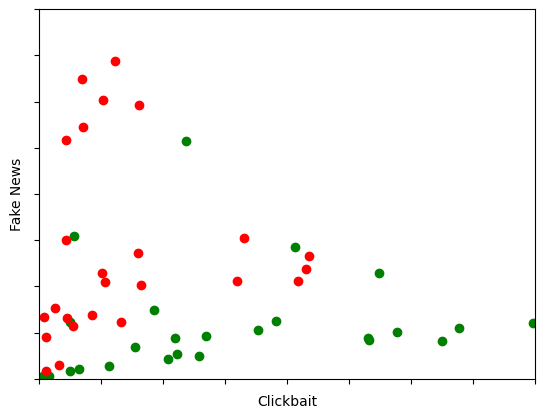

In [ ]:
import matplotlib.pyplot as plt
model.load_state_dict(torch.load(root + "model/modelFIN", map_location=torch.device('cpu')))
model.eval()
# only to train
#model = Mod(num_hidden = 300, num_outs = 2).to(device) 
#model.load_state_dict(torch.load(root + "model/modelFIN2"))\
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
criterion = torch.nn.CrossEntropyLoss()
epochs = 1
best_f1 = 0
x_click_points = []
y_click_points = []
for epoch in range(epochs):
    successes = 0
    ypred = []
    ytrue = []
    i = 0
    model.eval()
    with torch.no_grad():
        cnt = 0
        for data, target in testloader:
            cnt += 1                
            output = model(data.to(device))
            #print("DEBUG", output, output.to(device).cpu()[0][0][0].numpy(), output.sum().cpu(), target.to(device).cpu())
            ypred.append(output.argmax().cpu())
            ytrue.append(target.to(device).cpu()[0])
            
            if target.to(device).cpu()[0].numpy() == 1:
                y = output.to(device).cpu()[0][0][0].numpy()
                x = output.to(device).cpu()[0][0][1].numpy()
                x_click_points.append(abs(x + y))
                y_click_points.append(abs(x + y) / (abs(x) + abs(y)))

            if output.argmax() == target.to(device):
                successes += 1

            #else:
              #print(cnt, ytrue[cnt - 1], ypred[cnt - 1])


    tmp_f1 = f1_score(ytrue,ypred)
    print("EPOCH: " + str(epoch + 1) + " Accuracy:" + str(successes/len(testloader)) )
    print("F1: " + str(tmp_f1))
    print("AUC: " + str(roc_auc_score(ytrue,ypred)))



plt.scatter(x_click_points,y_click_points, c="green")
plt.scatter(y_fake_points,x_fake_points, c="red")

plt.xlabel("Clickbait")
plt.ylabel("Fake News")
ax = plt.gca()
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])
plt.axis([0.0, 0.2, 0.0, 0.2])
plt.show()

In [ ]:
# both train and test 
test2dfnn = pd.read_csv(root + 'ebd/mixed_click_in_fake1.tsv', delimiter='\t')

from torch import tensor
def converter(x):
    return eval(x)
    
test2dfnn['embedding'] = test2dfnn['embedding'].apply(converter)

testsetnn = TensorDataset(torch.stack(list(test2dfnn['embedding'])), torch.LongTensor(list(test2dfnn['label'])))
testloadernn = DataLoader(testsetnn)
print(len(testloadernn))

# both train and test 
test2dfnnn = pd.read_csv(root + 'ebd/mixed_fake_in_click1.tsv', delimiter='\t')

from torch import tensor
def converter(x):
    return eval(x)
    
test2dfnnn['embedding'] = test2dfnnn['embedding'].apply(converter)

testsetnnn = TensorDataset(torch.stack(list(test2dfnnn['embedding'])), torch.LongTensor(list(test2dfnnn['label'])))
testloadernnn = DataLoader(testsetnnn)
print(len(testloadernnn))





50
50


In [ ]:
from torch.nn.functional import normalize
model.load_state_dict(torch.load(root + "model/combined_model.pt", map_location=torch.device('cpu')))
model.eval()

# only to train
#model = Mod(num_hidden = 300, num_outs = 2).to(device) 
#model.load_state_dict(torch.load(root + "model/modelFIN2"))\
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
criterion = torch.nn.CrossEntropyLoss()
epochs = 1
best_f1 = 0
x_fake_points1 = []
y_fake_points1 = []
x_real_points1 = []
y_real_points1 = []
for epoch in range(epochs):
    successes = 0
    ypred = []
    ytrue = []
    i = 0
    model.eval()
    with torch.no_grad():
        cnt = 0
        for data, target in testloadernn:
            cnt += 1                
            output = model(data.to(device))
            ypred.append(output.argmax().cpu())
            ytrue.append(target.to(device).cpu()[0])
            
            if target.to(device).cpu()[0].numpy() == 0:
                y = output.to(device).cpu()[0][0][1].numpy()
                x = output.to(device).cpu()[0][0][0].numpy()
                x_fake_points1.append(abs(x + y))
                y_fake_points1.append(abs(x + y) / (abs(x) + abs(y)))
            if target.to(device).cpu()[0].numpy() == 1:
                y = output.to(device).cpu()[0][0][0].numpy()
                x = output.to(device).cpu()[0][0][1].numpy()
                x_real_points1.append(0.2 - (abs(x + y) / (abs(x) + abs(y))))
                y_real_points1.append(0.2 - abs(x + y))


            if output.argmax() == target.to(device):
                successes += 1

            #else:
              #print(cnt, ytrue[cnt - 1], ypred[cnt - 1])


    tmp_f1 = f1_score(ytrue,ypred)
    print("EPOCH: " + str(epoch + 1) + " Accuracy:" + str(successes/len(testloader)) )
    print("F1: " + str(tmp_f1))
    print("AUC: " + str(roc_auc_score(ytrue,ypred)))

for epoch in range(epochs):
    successes = 0
    ypred = []
    ytrue = []
    i = 0
    model.eval()
    with torch.no_grad():
        cnt = 0
        for data, target in testloadern:
            cnt += 1                
            output = model(data.to(device))
            ypred.append(output.argmax().cpu())
            ytrue.append(target.to(device).cpu()[0])
            
            """
            if target.to(device).cpu()[0].numpy() == 0:
                y = output.to(device).cpu()[0][0][1].numpy()
                x = output.to(device).cpu()[0][0][0].numpy()
                x_fake_points1.append(abs(x + y))
                y_fake_points1.append(abs(x + y) / (abs(x) + abs(y)))
            if target.to(device).cpu()[0].numpy() == 1:
                y = output.to(device).cpu()[0][0][0].numpy()
                x = output.to(device).cpu()[0][0][1].numpy()
                x_real_points1.append(0.2 - (abs(x + y) / (abs(x) + abs(y))))
                y_real_points1.append(0.2 -abs(x + y))
            """
            if output.argmax() == target.to(device):
                successes += 1

            #else:
              #print(cnt, ytrue[cnt - 1], ypred[cnt - 1])


    tmp_f1 = f1_score(ytrue,ypred)
    print("EPOCH: " + str(epoch + 1) + " Accuracy:" + str(successes/len(testloader)) )
    print("F1: " + str(tmp_f1))
    print("AUC: " + str(roc_auc_score(ytrue,ypred)))

EPOCH: 1 Accuracy:0.84
F1: 0.8
AUC: 0.8292282430213465
EPOCH: 1 Accuracy:0.84
F1: 0.8
AUC: 0.8292282430213465


In [ ]:
from torch.nn.functional import normalize
model.load_state_dict(torch.load(root + "model/modelFIN", map_location=torch.device('cpu')))
model.eval()

# only to train
#model = Mod(num_hidden = 300, num_outs = 2).to(device) 
#model.load_state_dict(torch.load(root + "model/modelFIN2"))\
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
criterion = torch.nn.CrossEntropyLoss()
epochs = 1
best_f1 = 0
x_click_points1 = []
y_click_points1 = []
x_real_points2 = []
y_real_points2 = []
for epoch in range(epochs):
    successes = 0
    ypred = []
    ytrue = []
    i = 0
    model.eval()
    with torch.no_grad():
        cnt = 0
        for data, target in testloadernnn:
            cnt += 1                
            output = model(data.to(device))
            ypred.append(output.argmax().cpu())
            ytrue.append(target.to(device).cpu()[0])
            
            if target.to(device).cpu()[0].numpy() == 0:
                y = output.to(device).cpu()[0][0][1].numpy()
                x = output.to(device).cpu()[0][0][0].numpy()
                x_real_points2.append(0.2 - (abs(x + y) / (abs(x) + abs(y))))
                y_real_points2.append(0.2 - abs(x + y))
            if target.to(device).cpu()[0].numpy() == 1:
                y = output.to(device).cpu()[0][0][0].numpy()
                x = output.to(device).cpu()[0][0][1].numpy()     
                x_click_points1.append(abs(x + y))
                y_click_points1.append(abs(x + y) / (abs(x) + abs(y)))


            if output.argmax() == target.to(device):
                successes += 1

            #else:
              #print(cnt, ytrue[cnt - 1], ypred[cnt - 1])


    tmp_f1 = f1_score(ytrue,ypred)
    print("EPOCH: " + str(epoch + 1) + " Accuracy:" + str(successes/len(testloader)) )
    print("F1: " + str(tmp_f1))
    print("AUC: " + str(roc_auc_score(ytrue,ypred)))

for epoch in range(epochs):
    successes = 0
    ypred = []
    ytrue = []
    i = 0
    model.eval()
    with torch.no_grad():
        cnt = 0
        for data, target in testloader:
            cnt += 1                
            output = model(data.to(device))
            ypred.append(output.argmax().cpu())
            ytrue.append(target.to(device).cpu()[0])

            """
            if target.to(device).cpu()[0].numpy() == 0:
                y = output.to(device).cpu()[0][0][1].numpy()
                x = output.to(device).cpu()[0][0][0].numpy()
                x_real_points2.append(0.2 - (abs(x + y) / (abs(x) + abs(y))))
                y_real_points2.append(0.2 - abs(x + y))

            if target.to(device).cpu()[0].numpy() == 1:
                y = output.to(device).cpu()[0][0][0].numpy()
                x = output.to(device).cpu()[0][0][1].numpy()
                x_click_points1.append(abs(x + y))
                y_click_points1.append(abs(x + y) / (abs(x) + abs(y)))
            """

            if output.argmax() == target.to(device):
                successes += 1

            #else:
              #print(cnt, ytrue[cnt - 1], ypred[cnt - 1])


    tmp_f1 = f1_score(ytrue,ypred)
    print("EPOCH: " + str(epoch + 1) + " Accuracy:" + str(successes/len(testloader)) )
    print("F1: " + str(tmp_f1))
    print("AUC: " + str(roc_auc_score(ytrue,ypred)))

EPOCH: 1 Accuracy:0.56
F1: 0.5
AUC: 0.5944170771756979
EPOCH: 1 Accuracy:0.56
F1: 0.5
AUC: 0.5944170771756979


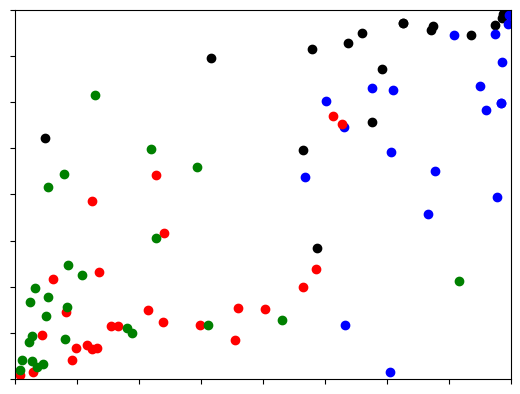

In [ ]:
import matplotlib.pyplot as plt

plt.scatter(y_real_points2,x_real_points2, c="black")
plt.scatter(x_real_points1,y_real_points1, c="blue")
plt.scatter(x_click_points1,y_click_points1, c="red")
plt.scatter(y_fake_points1,x_fake_points1, c="green")

#plt.xlabel("Clickbait")
#plt.ylabel("Fake News")
ax = plt.gca()
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])
plt.axis([0.0, 0.2, 0.0, 0.2])
plt.show()


In [ ]:
from torch.nn.functional import normalize
model.load_state_dict(torch.load(root + "model/combined_model.pt", map_location=torch.device('cpu')))
model.eval()

# only to train
#model = Mod(num_hidden = 300, num_outs = 2).to(device) 
#model.load_state_dict(torch.load(root + "model/modelFIN2"))\
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
criterion = torch.nn.CrossEntropyLoss()
epochs = 1
best_f1 = 0
x_fake_points1r = []
y_fake_points1r = []
x_real_points1r = []
y_real_points1r = []

x_fake_points1w = []
y_fake_points1w = []
x_real_points1w = []
y_real_points1w = []

for epoch in range(epochs):
    successes = 0
    ypred = []
    ytrue = []
    i = 0
    model.eval()
    with torch.no_grad():
        cnt = 0
        for data, target in testloadernn:
            cnt += 1                
            output = model(data.to(device))
            ypred.append(output.argmax().cpu())
            ytrue.append(target.to(device).cpu()[0])

            if output.argmax() == target.to(device):
                successes += 1
                if target.to(device).cpu()[0].numpy() == 0:
                    y = output.to(device).cpu()[0][0][1].numpy()
                    x = output.to(device).cpu()[0][0][0].numpy()
                    #x_fake_points1r.append(abs(x + y))
                    #y_fake_points1r.append(abs(x + y) / (abs(x) + abs(y)))
                if target.to(device).cpu()[0].numpy() == 1:
                    y = output.to(device).cpu()[0][0][0].numpy()
                    x = output.to(device).cpu()[0][0][1].numpy()
                    #x_real_points1r.append(0.2 - (abs(x + y) / (abs(x) + abs(y))))
                    #y_real_points1r.append(0.2 - abs(x + y))

            else:
                if target.to(device).cpu()[0].numpy() == 0:
                    y = output.to(device).cpu()[0][0][1].numpy()
                    x = output.to(device).cpu()[0][0][0].numpy()
                    #x_fake_points1w.append(abs(x + y))
                    #y_fake_points1w.append(abs(x + y) / (abs(x) + abs(y)))
                if target.to(device).cpu()[0].numpy() == 1:
                    y = output.to(device).cpu()[0][0][0].numpy()
                    x = output.to(device).cpu()[0][0][1].numpy()
                    #x_real_points1w.append(0.2 - (abs(x + y) / (abs(x) + abs(y))))
                    #y_real_points1w.append(0.2 - abs(x + y))


    tmp_f1 = f1_score(ytrue,ypred)
    print("EPOCH: " + str(epoch + 1) + " Accuracy:" + str(successes/len(testloader)) )
    print("F1: " + str(tmp_f1))
    print("AUC: " + str(roc_auc_score(ytrue,ypred)))

for epoch in range(epochs):
    successes = 0
    ypred = []
    ytrue = []
    i = 0
    model.eval()
    with torch.no_grad():
        cnt = 0
        for data, target in testloadern:
            cnt += 1                
            output = model(data.to(device))
            ypred.append(output.argmax().cpu())
            ytrue.append(target.to(device).cpu()[0])
          
            if output.argmax() == target.to(device):
                successes += 1
                if target.to(device).cpu()[0].numpy() == 0:
                    y = output.to(device).cpu()[0][0][1].numpy()
                    x = output.to(device).cpu()[0][0][0].numpy()
                    x_fake_points1r.append(abs(x + y))
                    y_fake_points1r.append(abs(x + y) / (abs(x) + abs(y)))
                if target.to(device).cpu()[0].numpy() == 1:
                    y = output.to(device).cpu()[0][0][0].numpy()
                    x = output.to(device).cpu()[0][0][1].numpy()
                    x_real_points1r.append(0.2 - (abs(x + y) / (abs(x) + abs(y))))
                    y_real_points1r.append(0.2 -abs(x + y))

            else:
                if target.to(device).cpu()[0].numpy() == 0:
                    y = output.to(device).cpu()[0][0][1].numpy()
                    x = output.to(device).cpu()[0][0][0].numpy()
                    x_fake_points1w.append(abs(x + y))
                    y_fake_points1w.append(abs(x + y) / (abs(x) + abs(y)))
                if target.to(device).cpu()[0].numpy() == 1:
                    y = output.to(device).cpu()[0][0][0].numpy()
                    x = output.to(device).cpu()[0][0][1].numpy()
                    x_real_points1w.append(0.2 - (abs(x + y) / (abs(x) + abs(y))))
                    y_real_points1w.append(0.2 -abs(x + y))



    tmp_f1 = f1_score(ytrue,ypred)
    print("EPOCH: " + str(epoch + 1) + " Accuracy:" + str(successes/len(testloader)) )
    print("F1: " + str(tmp_f1))
    print("AUC: " + str(roc_auc_score(ytrue,ypred)))

EPOCH: 1 Accuracy:0.84
F1: 0.8
AUC: 0.8292282430213465
EPOCH: 1 Accuracy:0.82
F1: 0.7804878048780488
AUC: 0.8119868637110016


In [ ]:
from torch.nn.functional import normalize
model.load_state_dict(torch.load(root + "model/modelFIN", map_location=torch.device('cpu')))
model.eval()

# only to train
#model = Mod(num_hidden = 300, num_outs = 2).to(device) 
#model.load_state_dict(torch.load(root + "model/modelFIN2"))\
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
criterion = torch.nn.CrossEntropyLoss()
epochs = 1
best_f1 = 0
x_click_points1r = []
y_click_points1r = []
x_real_points2r = []
y_real_points2r = []

x_click_points1w = []
y_click_points1w = []
x_real_points2w = []
y_real_points2w = []
for epoch in range(epochs):
    successes = 0
    ypred = []
    ytrue = []
    i = 0
    model.eval()
    with torch.no_grad():
        cnt = 0
        for data, target in testloadernnn:
            cnt += 1                
            output = model(data.to(device))
            ypred.append(output.argmax().cpu())
            ytrue.append(target.to(device).cpu()[0])
          

            if output.argmax() == target.to(device):
                successes += 1
                if target.to(device).cpu()[0].numpy() == 0:
                    y = output.to(device).cpu()[0][0][1].numpy()
                    x = output.to(device).cpu()[0][0][0].numpy()
                    #x_real_points2r.append(0.2 - (abs(x + y) / (abs(x) + abs(y))))
                    #y_real_points2r.append(0.2 - abs(x + y))
                if target.to(device).cpu()[0].numpy() == 1:
                    y = output.to(device).cpu()[0][0][0].numpy()
                    x = output.to(device).cpu()[0][0][1].numpy()
                    
                    #x_click_points1r.append(abs(x + y))
                    #y_click_points1r.append(abs(x + y) / (abs(x) + abs(y)))

            else:
              if output.argmax() == target.to(device):
                successes += 1
                if target.to(device).cpu()[0].numpy() == 0:
                    y = output.to(device).cpu()[0][0][1].numpy()
                    x = output.to(device).cpu()[0][0][0].numpy()
                    #x_real_points2w.append(0.2 - (abs(x + y) / (abs(x) + abs(y))))
                    #y_real_points2w.append(0.2 - abs(x + y))
                if target.to(device).cpu()[0].numpy() == 1:
                    y = output.to(device).cpu()[0][0][0].numpy()
                    x = output.to(device).cpu()[0][0][1].numpy()
                    
                    #x_click_points1w.append(abs(x + y))
                    #y_click_points1w.append(abs(x + y) / (abs(x) + abs(y)))



    tmp_f1 = f1_score(ytrue,ypred)
    print("EPOCH: " + str(epoch + 1) + " Accuracy:" + str(successes/len(testloader)) )
    print("F1: " + str(tmp_f1))
    print("AUC: " + str(roc_auc_score(ytrue,ypred)))

for epoch in range(epochs):
    successes = 0
    ypred = []
    ytrue = []
    i = 0
    model.eval()
    with torch.no_grad():
        cnt = 0
        for data, target in testloader:
            cnt += 1                
            output = model(data.to(device))
            ypred.append(output.argmax().cpu())
            ytrue.append(target.to(device).cpu()[0])
            
            


            if output.argmax() == target.to(device):
                successes += 1
                if target.to(device).cpu()[0].numpy() == 0:
                    y = output.to(device).cpu()[0][0][1].numpy()
                    x = output.to(device).cpu()[0][0][0].numpy()
                    x_real_points2r.append(0.2 - (abs(x + y) / (abs(x) + abs(y))))
                    y_real_points2r.append(0.2 - abs(x + y))
                    
                if target.to(device).cpu()[0].numpy() == 1:
                    y = output.to(device).cpu()[0][0][0].numpy()
                    x = output.to(device).cpu()[0][0][1].numpy()
                    x_click_points1r.append(abs(x + y))
                    y_click_points1r.append(abs(x + y) / (abs(x) + abs(y)))

            else:
                if target.to(device).cpu()[0].numpy() == 0:
                    y = output.to(device).cpu()[0][0][1].numpy()
                    x = output.to(device).cpu()[0][0][0].numpy()
                    x_real_points2.append(0.2 - (abs(x + y) / (abs(x) + abs(y))))
                    y_real_points2.append(0.2 - abs(x + y))
                if target.to(device).cpu()[0].numpy() == 1:
                    y = output.to(device).cpu()[0][0][0].numpy()
                    x = output.to(device).cpu()[0][0][1].numpy()
                    
                    x_click_points1w.append(abs(x + y))
                    y_click_points1w.append(abs(x + y) / (abs(x) + abs(y)))


    tmp_f1 = f1_score(ytrue,ypred)
    print("EPOCH: " + str(epoch + 1) + " Accuracy:" + str(successes/len(testloader)) )
    print("F1: " + str(tmp_f1))
    print("AUC: " + str(roc_auc_score(ytrue,ypred)))

EPOCH: 1 Accuracy:0.56
F1: 0.5
AUC: 0.5944170771756979
EPOCH: 1 Accuracy:0.9
F1: 0.9180327868852458
AUC: 0.88752052545156


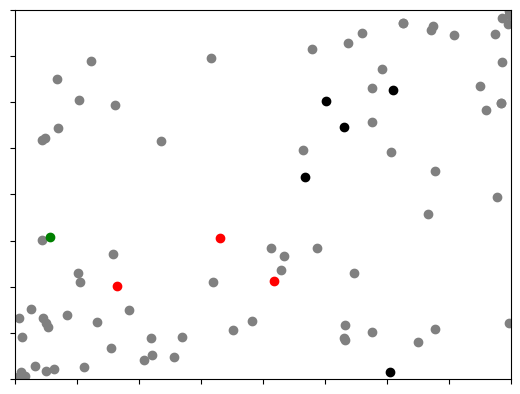

In [ ]:
plt.scatter(y_real_points2r,x_real_points2r, c="grey")
plt.scatter(x_real_points1r,y_real_points1r, c="grey")
plt.scatter(x_click_points1r,y_click_points1r, c="grey")
plt.scatter(y_fake_points1r,x_fake_points1r, c="grey")

plt.scatter(y_real_points2w,x_real_points2w, c="blue")
plt.scatter(x_real_points1w,y_real_points1w, c="black")
plt.scatter(x_click_points1w,y_click_points1w, c="green")
plt.scatter(y_fake_points1w,x_fake_points1w, c="red")

#plt.xlabel("Clickbait")
#plt.ylabel("Fake News")
ax = plt.gca()
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])
plt.axis([0.0, 0.2, 0.0, 0.2])
plt.show()


In [ ]:
# only to test all models and datasets
#names = ["A", "B", "C", "ABC", "FNC", "FIN"]
#names = ["FIN"]

data_name = 'FIN'
test2df = pd.read_csv(root + '/ebd/testebd' + data_name + '.tsv', delimiter='\t')
from torch import tensor
def converter(x):
    return eval(x)
    
test2df['embedding'] = test2df['embedding'].apply(converter)

testset = TensorDataset(torch.stack(list(test2df['embedding'])), torch.LongTensor(list(test2df['label'])))
testloader = DataLoader(testset)
print(len(testloader))

RuntimeError: ignored

In [ ]:
model.load_state_dict(torch.load(root + "/model/combined_model.pt"))
model.eval()

successes = 0
ypred = []
ytrue = []
with torch.no_grad():
    for data, target in testloader:                
        output = model(data.to(device))
        ypred.append(output.argmax().cpu())
        ytrue.append(target.to(device).cpu()[0])

        print("DEUBG",output.argmax().cpu(), target.to(device).cpu()[0])
        
        
        if output.argmax() != target.to(device):
            successes += 1

print("DATA: ", data_name, " MODEL: FAKE",)
print("Accuracy:" + str(successes/len(testloader)) )
print("F1: " + str(f1_score(ytrue,ypred)))
print("AUC: " + str(roc_auc_score(ytrue,ypred)))
print("")

In [ ]:
fake in fake
19 tensor(1) tensor(0)
20 tensor(1) tensor(0)
24 tensor(0) tensor(1)
28 tensor(1) tensor(0)
29 tensor(0) tensor(1)
34 tensor(1) tensor(0)
35 tensor(1) tensor(0)
40 tensor(0) tensor(1)
47 tensor(0) tensor(1)
EPOCH: 1 Accuracy:0.82
F1: 0.7804878048780488
AUC: 0.8119868637110016

click in click
18 tensor(0) tensor(1)
20 tensor(0) tensor(1)
28 tensor(0) tensor(1)
35 tensor(0) tensor(1)
44 tensor(1) tensor(0)
EPOCH: 1 Accuracy:0.9
F1: 0.9180327868852458
AUC: 0.88752052545156

fake in click
1 tensor(1) tensor(0)
3 tensor(1) tensor(0)
9 tensor(1) tensor(0)
11 tensor(1) tensor(0)
18 tensor(0) tensor(1)
20 tensor(0) tensor(1)
21 tensor(1) tensor(0)
24 tensor(1) tensor(0)
25 tensor(1) tensor(0)
27 tensor(1) tensor(0)
28 tensor(0) tensor(1)
29 tensor(1) tensor(0)
33 tensor(1) tensor(0)
35 tensor(0) tensor(1)
37 tensor(1) tensor(0)
42 tensor(1) tensor(0)
43 tensor(1) tensor(0)
44 tensor(1) tensor(0)
45 tensor(1) tensor(0)
46 tensor(1) tensor(0)
47 tensor(1) tensor(0)
49 tensor(1) tensor(0)
EPOCH: 1 Accuracy:0.56
F1: 0.5
AUC: 0.5944170771756979

click in fake:
19 tensor(1) tensor(0)
20 tensor(1) tensor(0)
24 tensor(0) tensor(1)
28 tensor(1) tensor(0)
34 tensor(1) tensor(0)
35 tensor(1) tensor(0)
44 tensor(0) tensor(1)
45 tensor(0) tensor(1)
EPOCH: 1 Accuracy:0.84
F1: 0.8
AUC: 0.8292282430213465


In [ ]:
2

76456
DATA:  FIN2  MODEL:  FIN2
0.18047569537829364


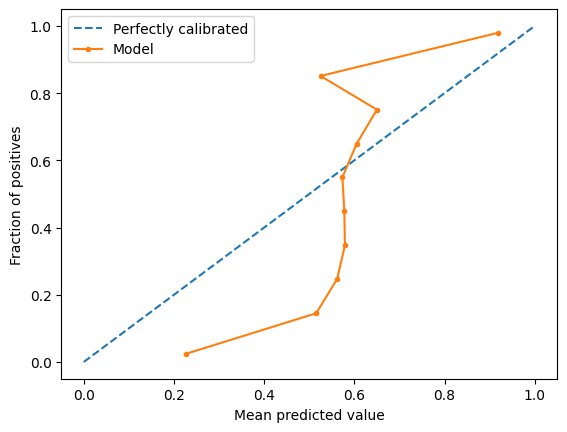

In [ ]:
# to get calibaration curve
import sklearn.calibration
import numpy as np
import matplotlib.pyplot as plt

names = ["FIN2"]

for data_name in names:
  test2df = pd.read_csv(root + '/ebd/testebd' + data_name + '.tsv', delimiter='\t')
  from torch import tensor
  def converter(x):
      return eval(x)
      
  test2df['embedding'] = test2df['embedding'].apply(converter)

  testset = TensorDataset(torch.stack(list(test2df['embedding'])), torch.LongTensor(list(test2df['label'])))
  testloader = DataLoader(testset)
  print(len(testloader))

  for model_name in names:
    print("DATA: ", data_name, " MODEL: ", model_name)

    model.load_state_dict(torch.load(root + "/model/model" + model_name))
    model.eval()

    test_outputs = model(torch.stack(list(test2df['embedding'])))
    test_outputs = torch.softmax(test_outputs, dim =2)
    test_outputs = test_outputs[:,:,1].cpu()

    predictions = test_outputs.detach().numpy().flatten()

    # Calculate the calibration curve

    bins = np.linspace(0, 1, num=10)
    mean_predicted_value, fraction_of_positives = sklearn.calibration.calibration_curve(((test2df['label'])), predictions, n_bins=10)
    ece = 0
    for i in range(len(mean_predicted_value)):
        ece += np.abs(mean_predicted_value[i] - fraction_of_positives[i])/10
    print(ece)



    # Plot the calibration curve
    fig, ax = plt.subplots()
    ax.plot([0, 1], [0, 1], linestyle='--', label='Perfectly calibrated')
    ax.plot(mean_predicted_value, fraction_of_positives, marker='.', label='Model')
    ax.set_xlabel('Mean predicted value')
    ax.set_ylabel('Fraction of positives')
    ax.set_ylim([-0.05, 1.05])
    ax.legend()
    plt.show()
